<a href="https://colab.research.google.com/github/maetthil/NASASpaceApps/blob/main/Read_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%%capture
!pip install cdflib
!pip install bs4

In [13]:
import glob
import cdflib 
import sys
import os
import requests
import pytz
import datetime
import pandas as pd
from bs4 import BeautifulSoup as bs
from tqdm import tqdm

import matplotlib.pyplot as plt

In [14]:
DATASET_PATH = 'dataset/'

In [15]:
def download_bwt_file(year='2018', data='wind', n=10):
    if data == 'dscovr':
        url = f'https://cdaweb.gsfc.nasa.gov/pub/data/dscovr/h0/mag/{year}/' 
    elif data == 'wind':
        url = f'https://cdaweb.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/{year}/'
    elif data == 'wind_ion':
        url = f'https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/{year}/'
    else:
        raise Exception('Conjunto de dados desconhecido')
    content = requests.get(url).content
    DATA_FOLDER = 'dataset/'
    if not os.path.exists(os.path.join(DATA_FOLDER, data)):
        os.makedirs(os.path.join(DATA_FOLDER, data))
    links = bs(content).findAll('a', href=True)
    print (f'Baixando arquivos de dados de {year}')
    downloaded = 0
    for link in tqdm(links):
        if downloaded == n:
            break
        filename = link['href']
        if filename.find('.cdf') < 0:
            continue
        response = requests.get(f'{url}{filename}')
        with open(f'{DATA_FOLDER}{data}/{filename}', 'wb') as f:
            f.write(response.content)
        downloaded += 1

In [16]:
download_bwt_file(data='wind')

Baixando arquivos de dados de 2018


  4%|▍         | 14/369 [01:02<26:25,  4.47s/it]


In [17]:
download_bwt_file(data='dscovr')

Baixando arquivos de dados de 2018


  4%|▍         | 14/369 [00:14<06:03,  1.02s/it]


In [18]:
download_bwt_file(data='wind_ion')

Baixando arquivos de dados de 2018


  4%|▍         | 14/369 [00:03<01:33,  3.80it/s]


## Leitura de dados

In [19]:
def load_cdf_files(data='wind'):
    if data == 'dscovr':
        base = 'dataset/dscovr/'
    elif data == 'wind':
        base = 'dataset/wind/'
    elif data == 'wind_ion':
        base = 'dataset/wind_ion/'
    else:
        raise Exception('Conjunto de dados desconhecido')
    files = glob.glob(os.path.join(base, '*.cdf'))
    for f in files:
        yield cdflib.cdf_to_xarray(f)

In [20]:
dscovr_ds = load_cdf_files(data='dscovr')
wind_ds = load_cdf_files(data='wind')
wind_ion_ds = load_cdf_files(data='wind_ion')

In [22]:
dscovr = next(dscovr_ds)
wind = next(wind_ds)
wind_ion = next(wind_ion_ds)

## Step one

In [38]:
magnetic_field_wind = wind["BGSM"]
magnetic_field_dscovr = dscovr["B1GSE"]
magnetic_field_dscovr

<xarray.DataArray 'B1GSE' (Epoch1: 86400, dim0: 3)>
array([[ 2.1642692 , -2.3275354 ,  0.7199299 ],
       [ 2.1277125 , -2.3266327 ,  0.7754415 ],
       [ 2.1846945 , -2.3422647 ,  0.8194216 ],
       ...,
       [ 2.2377372 ,  1.2122128 , -0.08902374],
       [ 2.290608  ,  1.1840001 , -0.07946623],
       [ 2.3379135 ,  1.1640143 , -0.1319383 ]], dtype=float32)
Coordinates:
  * Epoch1   (Epoch1) float64 6.368e+13 6.368e+13 ... 6.368e+13 6.368e+13
Dimensions without coordinates: dim0
Attributes:
    FIELDNAM:       Magnetic field vector in GSE cartesian coordinates (1 sec)
    VALIDMIN:       [-65534. -65534. -65534.]
    VALIDMAX:       [65534. 65534. 65534.]
    SCALEMIN:       [-2.3044431 -4.913537  -4.1959124]
    SCALEMAX:       [3.6900837 3.0832992 5.075633 ]
    UNITS:          nT
    FORMAT:         E13.6
    MONOTON:        FALSE
    SCALETYP:       LINEAR
    CATDESC:        Magnetic field vector in GSE cartesian coordinates (1 sec)
    FILLVAL:        [-1.e+31]
    LABL_PTR_1:     label_bgse
    DEPEND_0:       Epoch1
    VAR_TYPE:       data
    DISPLAY_TYPE:   time_series
    TIME_RES:       1 sec
    standard_name:  Magnetic field vector in GSE cartesian coordinates (1 sec)
    units:          nT

In [43]:
magnetic_field_dscovr_masked = magnetic_field_dscovr.where(magnetic_field_dscovr != -1.e+31)

In [45]:
magnetic_field_dscovr_masked


<xarray.DataArray 'B1GSE' (Epoch1: 86400, dim0: 3)>
array([[ 2.1642692 , -2.3275354 ,  0.7199299 ],
       [ 2.1277125 , -2.3266327 ,  0.7754415 ],
       [ 2.1846945 , -2.3422647 ,  0.8194216 ],
       ...,
       [ 2.2377372 ,  1.2122128 , -0.08902374],
       [ 2.290608  ,  1.1840001 , -0.07946623],
       [ 2.3379135 ,  1.1640143 , -0.1319383 ]], dtype=float32)
Coordinates:
  * Epoch1   (Epoch1) float64 6.368e+13 6.368e+13 ... 6.368e+13 6.368e+13
Dimensions without coordinates: dim0
Attributes:
    FIELDNAM:       Magnetic field vector in GSE cartesian coordinates (1 sec)
    VALIDMIN:       [-65534. -65534. -65534.]
    VALIDMAX:       [65534. 65534. 65534.]
    SCALEMIN:       [-2.3044431 -4.913537  -4.1959124]
    SCALEMAX:       [3.6900837 3.0832992 5.075633 ]
    UNITS:          nT
    FORMAT:         E13.6
    MONOTON:        FALSE
    SCALETYP:       LINEAR
    CATDESC:        Magnetic field vector in GSE cartesian coordinates (1 sec)
    FILLVAL:        [-1.e+31]
    LABL_PTR_1:     label_bgse
    DEPEND_0:       Epoch1
    VAR_TYPE:       data
    DISPLAY_TYPE:   time_series
    TIME_RES:       1 sec
    standard_name:  Magnetic field vector in GSE cartesian coordinates (1 sec)
    units:          nT

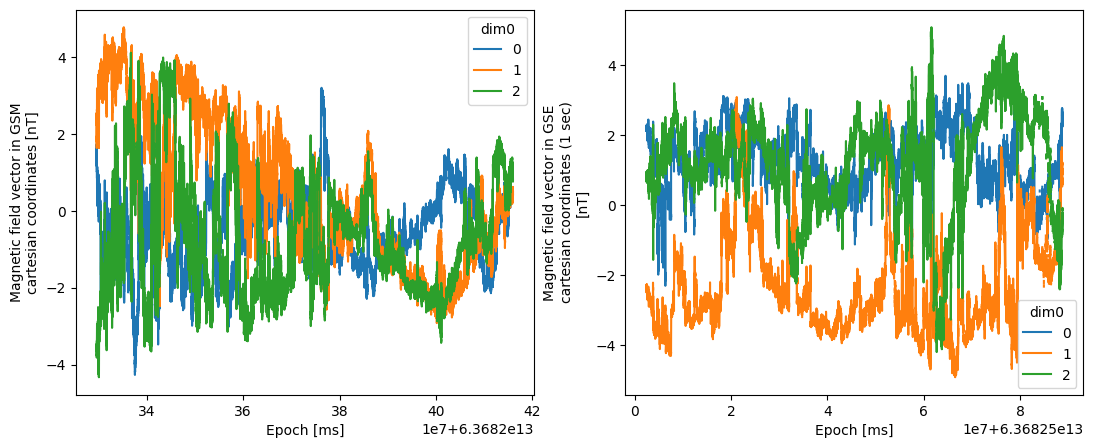

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 5))
fig.add_subplot(1, 2, 1)
magnetic_field_wind.plot.line(x="Epoch")
fig.add_subplot(1, 2, 2)
magnetic_field_dscovr_masked.plot.line(x="Epoch1")
plt.show()

## Step two

## Step three

In [ ]:
#Ion parameters we need
# density n(D(t))
# temperature w(D(t))
# velocity n(D(t))

In [ ]:
dscovr

<xarray.Dataset>
Dimensions:       (Epoch1: 86400, unit_time: 3, dim0: 3, dim1: 8)
Coordinates:
  * Epoch1        (Epoch1) float64 6.381e+13 6.381e+13 ... 6.381e+13 6.381e+13
  * unit_time     (unit_time) <U4 'year' 'day ' 'msec'
    label_time    (unit_time) <U27 'Year                       ' ... 'Elapsed...
Dimensions without coordinates: dim0, dim1
Data variables: (12/17)
    Time1_PB5     (Epoch1, unit_time) int32 2022 1 500 2022 ... 2022 1 86399500
    NUM1_PTS      (Epoch1) int32 50 50 50 50 50 50 50 ... 50 50 50 50 50 50 50
    B1F1          (Epoch1) float32 7.848 7.856 7.873 7.901 ... 6.998 7.047 7.066
    B1SDF1        (Epoch1) float32 0.06583 0.06617 0.06173 ... 0.05589 0.0731
    B1GSE         (Epoch1, dim0) float32 -6.047 1.366 -4.811 ... 6.592 -1.773
    B1SDGSE       (Epoch1, dim0) float32 0.07016 0.06894 ... 0.09902 0.2387
    ...            ...
    SENS          (dim0, dim1) float32 -1e+31 0.008067 -1e+31 ... -1e+31 -1e+31
    format_time   (dim0) <U2 'I4' 'I3' 'I8'
    label_bgse    (dim0) <U8 'Bx (GSE)' 'By (GSE)' 'Bz (GSE)'
    label_bsdgse  (dim0) <U14 'Bx_SIGMA (GSE)' 'By_SIGMA (GSE)' 'Bz_SIGMA (GSE)'
    label_brtn    (dim0) <U8 'Br (RTN)' 'Bt (RTN)' 'Bn (RTN)'
    label_bsdrtn  (dim0) <U14 'Br_SIGMA (RTN)' 'Bt_SIGMA (RTN)' 'Bn_SIGMA (RTN)'
Attributes: (12/21)
    Project:                     DSCOVR>Deep Space Climate Observatory
    Discipline:                  Space Physics>Heliospheric Science
    Source_name:                 DSCOVR>Deep Space Climate Observatory
    Software_version:            V01.00
    Data_type:                   H0>1-sec Definitive Data
    Descriptor:                  MAG>Fluxgate Magnetometer
    ...                          ...
    PI_name:                     A. Koval
    PI_affiliation:              UMBC, NASA/GSFC
    Mission_group:               DSCOVR
    Instrument_type:             Magnetic Fields (space)
    TEXT_supplement_1:            
    Web_sites:

In [ ]:
wind

<xarray.Dataset>
Dimensions:      (Epoch: 936625, unit_time: 3, dim0: 3, Epoch1: 1440, dim1: 8)
Coordinates:
  * Epoch        (Epoch) float64 6.381e+13 6.381e+13 ... 6.381e+13 6.381e+13
  * Epoch1       (Epoch1) float64 6.381e+13 6.381e+13 ... 6.381e+13 6.381e+13
  * unit_time    (unit_time) <U4 'year' 'day ' 'msec'
    label_time   (unit_time) <U27 'Year                       ' ... 'Elapsed ...
Dimensions without coordinates: dim0, dim1
Data variables: (12/26)
    Time_PB5     (Epoch, unit_time) int32 2022 9 56 2022 ... 2022 9 86399915
    BF1          (Epoch) float32 18.49 18.66 18.75 18.67 ... 3.47 3.529 3.579
    BGSM         (Epoch, dim0) float32 7.254 -15.92 5.981 ... -3.171 -1.626
    BGSE         (Epoch, dim0) float32 7.254 -13.23 10.68 ... -3.525 -0.5236
    RANGE        (Epoch) int32 2 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1 1
    SPC_MODE     (Epoch) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ...           ...
    PAYLD1_I     (Epoch1, dim0, dim0) float64 1.0 0.0 0.0 0.0 ... 0.0 0.0 -1.0
    FLAG1_I      (Epoch1) int32 5 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5 5 5
    format_time  (dim0) <U2 'I4' 'I3' 'I8'
    label_bgsm   (dim0) <U8 'Bx (GSM)' 'By (GSM)' 'Bz (GSM)'
    label_bgse   (dim0) <U8 'Bx (GSE)' 'By (GSE)' 'Bz (GSE)'
    cartesian    (dim0) <U11 'x-component' 'y-component' 'z-component'
Attributes: (12/28)
    Project:                     ISTP>International Solar-Terrestrial Physics
    Discipline:                  Space Physics>Heliospheric Science
    Source_name:                 WIND>Wind Interplanetary Plasma Laboratory
    Software_version:            V05.00
    Data_type:                   H2>High-resolution Definitive Data
    Descriptor:                  MFI>Magnetic Fields Investigation
    ...                          ...
    PI_name:                     A. Koval
    PI_affiliation:              UMBC, NASA/GSFC
    Mission_group:               Wind
    Instrument_type:             Magnetic Fields (space)
    TEXT_supplement_1:            
    Web_sites:                   http://wind.nasa.gov

In [ ]:
wind_ion

<xarray.Dataset>
Dimensions:                   (Epoch: 818)
Coordinates: (12/20)
  * Epoch                     (Epoch) float64 6.381e+13 6.381e+13 ... 6.381e+13
    Proton_sigmaV_nonlin      (Epoch) float32 62.6 65.02 65.3 ... 30.86 21.2
    Proton_sigmaVX_nonlin     (Epoch) float32 62.89 65.09 65.52 ... 30.95 21.27
    Proton_sigmaVY_nonlin     (Epoch) float32 21.19 8.174 14.83 ... 3.328 3.567
    Proton_sigmaVZ_nonlin     (Epoch) float32 6.81 3.74 7.307 ... 7.982 5.22
    Proton_sigmaW_nonlin      (Epoch) float32 14.0 11.83 13.02 ... 1e+05 3.977
    ...                        ...
    Alpha_sigmaVZ_nonlin      (Epoch) float32 1e+05 1e+05 1e+05 ... 32.87 38.16
    Alpha_sigmaW_nonlin       (Epoch) float32 14.0 11.83 13.02 ... 1e+05 3.977
    Alpha_sigmaWperp_nonlin   (Epoch) float32 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    Alpha_sigmaWpar_nonlin    (Epoch) float32 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    Alpha_sigmaNa_nonlin      (Epoch) float32 1e+05 1e+05 1e+05 ... 0.01 0.01
    sigmaPeak_doy             (Epoch) float64 4.424e-05 7.373e-05 ... 5.898e-05
Data variables: (12/41)
    fit_flag                  (Epoch) int8 0 6 6 6 6 6 6 0 ... 3 3 3 3 3 3 10 3
    year                      (Epoch) int8 -26 -26 -26 -26 ... -26 -26 -26 -26
    doy                       (Epoch) float32 3.0 3.001 3.004 ... 3.998 4.0
    Proton_V_nonlin           (Epoch) float32 476.8 466.3 476.9 ... 498.2 498.2
    Proton_VX_nonlin          (Epoch) float32 -474.5 -465.8 ... -496.6 -496.6
    Proton_VY_nonlin          (Epoch) float32 -43.09 -16.86 ... -12.76 -20.9
    ...                        ...
    dev                       (Epoch) float32 0.4888 0.4069 ... 0.07196 0.02197
    xgse                      (Epoch) float32 244.2 244.2 244.2 ... 245.3 245.3
    ygse                      (Epoch) float32 73.59 73.58 73.58 ... 71.24 71.24
    zgse                      (Epoch) float32 9.787 9.787 9.788 ... 10.05 10.05
    ygsm                      (Epoch) float32 68.13 68.13 68.15 ... 65.57 65.57
    zgsm                      (Epoch) float32 29.49 29.47 29.43 ... 29.62 29.61
Attributes: (12/19)
    Project:                     WIND/SWE Faraday Cup (Proton - Alpha Anisotr...
    Source_name:                 Wind
    Discipline:                  ['Space Physics>Magnetospheric Science', 'Sp...
    Data_type:                   VS>Validated Summary Data
    Descriptor:                  SWE>Solar Wind Experiment
    File_naming_convention:      source_datatype_descriptor
    ...                          ...
    Logical_file_id:             wi_h1_swe_20220103_v01
    Logical_source_description:  Solar wind proton and alpha parameters, incl...
    Time_resolution:             92 seconds
    Generated_by:                Michael L. Stevens (mstevens@cfa.harvard.edu)
    Generation_date:             Fri Feb 18 15:14:53 2022
    MODS:                        data analysis package revised March, 2012.

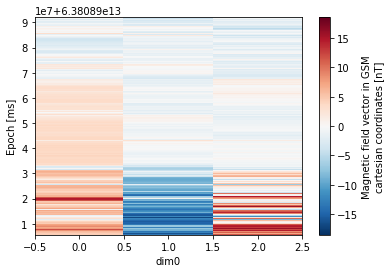

In [ ]:
# plot example 
wind['BGSM'].plot()